# Analysis of Algorithms

This script is used to analyse and evaluate the algorithms implemented the .py files.

Specifically, we will do the following:

1. Load the data to run our algorithms using ``load_opb.py``
2. Apply the Linear UCB implemnted in ``linUCB.py``
3. Evaluating the Algorithm. This gives an overview of how we will evaluate it and the Challenges. 
4. Evaluation using Doubly Robust Estimators


In [ ]:
from load_opb import load_obp_dataset
from linucb import linucb_all

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

/home/oliver/miniconda3/envs/RL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading Data

We will utilize the load_obp_dataset() function form ``load_obp.py``. This function loads the OBP data for a specific campaign and behavior policy (e.g., 'random' or 'bts'). It retrieves the context (features), action taken, observed reward, and propensity score (probability that the action was taken under the logging policy).

These components are essential for offline policy evaluation, where we want to estimate how well a new policy would perform based on logged data.

In [2]:
data = load_obp_dataset()
context = data["context"]
action = data["action"]
reward = data["reward"]
n_actions = data["n_actions"]
context_dim = context.shape[1]
alpha = 1.0


INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


## 2. Applying Linear UCB

In this section, we apply the imported the algorithm and apply it to our dataset. Before doing that, we need to initialize the design matrix for each action and the feature vector for each vector. This will be filled/changed when running the algorithm.

In [3]:
A = [np.identity(context_dim) for _ in range(n_actions)] #initialized A / V?: design matrix for each action
b = [np.zeros(context_dim) for _ in range(n_actions)] # initialized b: feature vector for each action


results = linucb_all(context, action, reward, A, b, alpha)
for key, value in results.items():
    print(f"{key}: {type(value).__name__}")
# this returns the dictionary from the linucb.py function linucb_all

results_01= linucb_all(context, action, reward, A, b, alpha = 0.1)

results_05 = linucb_all(context, action, reward, A, b, alpha = 0.5)

theta: list
A: list
b: list
chosen_actions: list
true_actions: ndarray
rewards: ndarray
ucb_scores: list


### Comparing Actions

In this section, we look at how often LinUCB selects the same action as the one taken by the logging (random) policy. At first glance, a low match rate (~1%) might seem concerning — but in an offline bandit setting, this is actually expected and not problematic.

We are not trying to **replicate** the behavior policy; instead, we aim to learn a **better policy**. Since the logged data was generated by a random policy, most of its actions are suboptimal. A low overlap between LinUCB’s actions and the logging policy’s actions simply means our learned policy is making **different choices**, which could lead to **higher expected rewards**.


In [13]:
# Print theta estimates

for i, theta in enumerate(results["theta"]):
    print(f"Arm {i} Coefficients: {np.round(theta, 2)}")

# Accuracy or decision match
import matplotlib.pyplot as plt

matches = np.array(results["chosen_actions"]) == np.array(results["true_actions"])
print(f" first few predictions: {results['chosen_actions'][:10]}")
print(f" first few true actions: {results['true_actions'][:10]}")


Arm 0 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 1 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 2 Coefficients: [ 0.   -0.01 -0.01 -0.    0.   -0.01  0.   -0.    0.    0.   -0.    0.01
  0.02 -0.    0.    0.    0.    0.01 -0.01 -0.  ]
Arm 3 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 4 Coefficients: [ 0.    0.03 -0.01 -0.    0.   -0.   -0.02 -0.02  0.   -0.02 -0.02 -0.01
 -0.02 -0.    0.    0.   -0.    0.    0.02  0.  ]
Arm 5 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 6 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 7 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Arm 8 Coefficients: [-0.   -0.01 -0.01 -0.01  0.   -0.01 -0.01  0.04  0.   -0.   -0.   -0.01
 -0.   -0.    0.   -0.02  0.    0.02  0.   -0.  ]
Arm 9 Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

We can observe that we do not have a great accucarcy. However, this might be due to the fact that we calculated the overall accucarcy. Due to the nature of the linear UCB algorithm, the accuracy should get better over time, as we simulte online learning. Let's investigate with a plot:

Cumulative Matches:


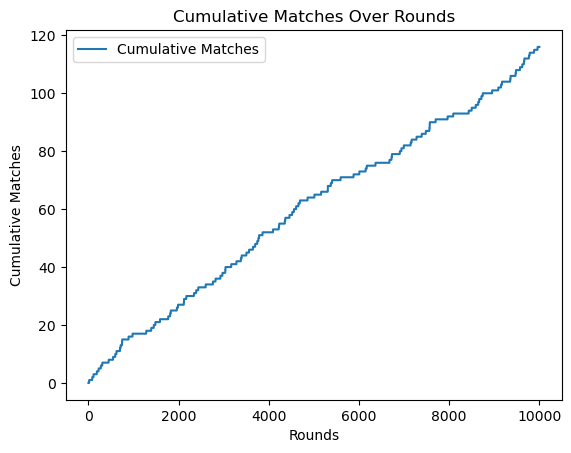

Cumulative Matches: [0 0 0 0 0 0 0 0 0 0]


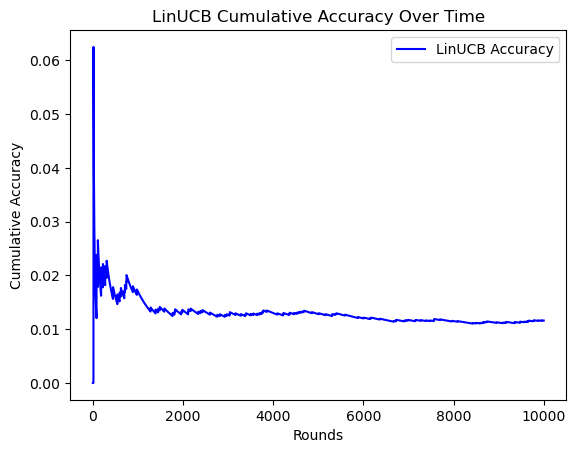

In [5]:

#.figure(figsize=(10, 5))
print("Cumulative Matches:")
plt.plot(np.cumsum(matches), label="Cumulative Matches")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Matches")
plt.title("Cumulative Matches Over Rounds")
plt.legend()
plt.show()

cumulative_matches = np.cumsum(matches)
#print first 10 cumulative matches

print(f"Cumulative Matches: {cumulative_matches[:10]}")
#  calculate accuracy over time

ideal_matches = (np.arange(1, len(matches) + 1))

accuracy_over_time = cumulative_matches / ideal_matches

plt.plot(accuracy_over_time, label='LinUCB Accuracy', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Accuracy')
plt.title('LinUCB Cumulative Accuracy Over Time')
plt.legend()
plt.show()

As described above, we can see how LinUCB’s selected action rarely matches the action chosen by the logging (random) policy. Overall, the low match rate (~1%) reflectes that LinUCB was learning a different policy.

To assess whether LinUCB is actually learning a better policy or not, we will from now on not rely on action-matching but instead evaluate **cumulative rewards** using offline policy evaluation methods.


## 3. Evaluating the Algorithm (offline Bandit evaluation)

To compare the random policy with LinUCB, we begin with a basic offline evaluation setup: LinUCB only receives reward when its chosen action matches the action logged by the random behavior policy. This setup is consistent with how offline bandit data is collected—only the reward for the logged action is observed.

However, this approach is highly biased. Since LinUCB typically selects different actions than the random policy (as we have seen), most of its potentially good decisions are ignored. As a result, the raw cumulative reward curve severely underestimates LinUCB's actual performance, as seen in the plot below.

To correct for this bias, we implement **Inverse Propensity Scoring (IPS)**. IPS reweights the observed rewards based on how likely the logging policy was to take the action. If LinUCB happens to select the same action as the logger, the reward is scaled by the inverse of the logging policy's probability of choosing it. This adjustment helps us estimate the expected performance of LinUCB, even though we only observe feedback for a small fraction of its actions.

In [6]:
print(f"chosen actions: {results['chosen_actions'][:100]}")
print(f"true actions: {results['true_actions'][:100]}")

chosen actions: [0, 1, 2, 3, 4, 0, 5, 6, 7, 8, 2, 0, 1, 1, 9, 10, 3, 11, 12, 13, 14, 15, 4, 16, 17, 18, 7, 5, 19, 20, 21, 22, 23, 6, 24, 8, 25, 10, 26, 27, 9, 12, 11, 14, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 13, 15, 39, 16, 40, 41, 42, 43, 44, 45, 2, 46, 47, 48, 49, 50, 51, 17, 52, 18, 24, 53, 54, 55, 56, 19, 57, 58, 59, 60, 61, 62, 63, 64, 20, 65, 66, 67, 68, 69, 70, 22, 71, 72, 73]
true actions: [14 14 27 48 36  4 70 56 17 55 15 67 45 21 10 10 69 69 43 40 34 68 37 62
 23 79 68 76 16 34 57 29 14 54 31 41 20 73 71 47 78 42 42 74 60 15 43 49
 60 30 22 15 29 77 56 20 63 37 71 13 57 37 31 12 41 36 18 26 29 36  9 11
 50 41 73 33 39 16 37 37 17 43 10 59 64 79 46 22 39 77 55 46 52 12 13 38
  6 14 14 50]


In [7]:
linucb_rewards = np.array(results["rewards"]) * matches

# Optional: convert to list
linucb_rewards = linucb_rewards.tolist()

# Print non-zero rewards
nonzero_rewards = [r for r in linucb_rewards if r > 0]
print(f"Number of valid LinUCB rewards > 0: {len(nonzero_rewards)}")
print(nonzero_rewards[:10])  # first 10


Number of valid LinUCB rewards > 0: 0
[]


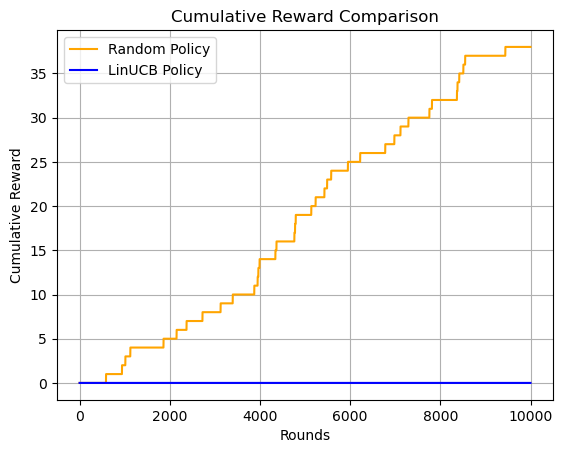

In [8]:

cumulative_random = np.cumsum(data["reward"])

# LinUCB reward
#linucb_reward = np.cumsum(results["rewards"])

plt.plot(cumulative_random, label='Random Policy', color='orange')

plt.plot(linucb_rewards, label='LinUCB Policy', color='blue')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()
plt.grid(True)
plt.show()

We will now implement **IPS** as described to see if this works better.

### IPS

IPS Weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
IPS Estimates: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total IPS Estimates: 0.0


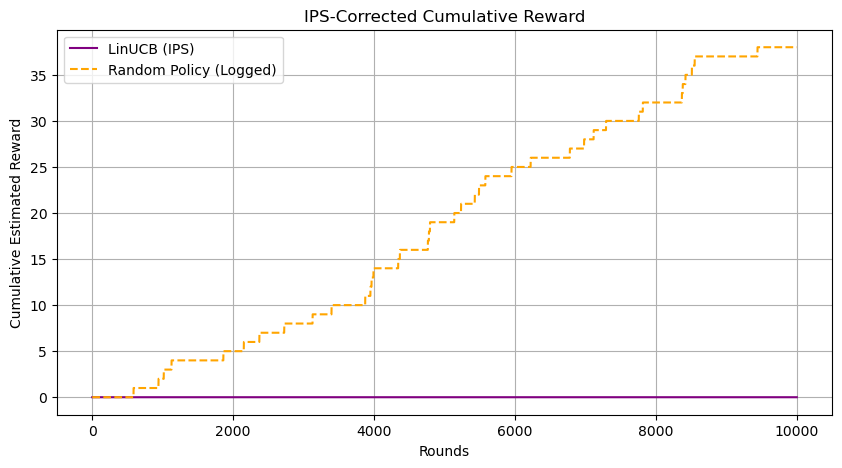

In [ ]:
chosen_actions = np.array(results["chosen_actions"])
logged_actions = np.array(data["action"])
rewards = np.array(data["reward"])
pscores = np.array(data["pscore"])

# Indicator: was LinUCB's action equal to the logged one?
matches = chosen_actions == logged_actions

# Apply IPS formula
ips_weights = matches / pscores  # ips_weights = matches / pscores  # (1 / pscore) if match, 0 otherwise
ips_estimates = ips_weights * rewards
print(f"IPS Weights: {ips_weights[:10]}")  # first 10 weights
print(f"IPS Estimates: {ips_estimates[:10]}")  # first 10
print(f"Total IPS Estimates: {ips_estimates.sum()}")
# Cumulative IPS reward over time
cumulative_ips = np.cumsum(ips_estimates)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_ips, label="LinUCB (IPS)", color="purple")
plt.plot(np.cumsum(rewards), label="Random Policy (Logged)", color="orange", linestyle="--")
plt.title("IPS-Corrected Cumulative Reward")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.legend()
plt.grid(True)
plt.show()

**Results**

Even with IPS correction, we find that LinUCB still appears to have zero or near-zero reward. This is due to the following: LinUCB rarely matches the action selected by the random logging policy, and even when it does, the observed reward is zero. As a result, the Inverse Propensity Scoring (IPS) estimate of LinUCB’s expected reward is also zero. 

However, this should not be interpreted as poor performance. In fact, it indicates that LinUCB is likely learning to avoid the suboptimal actions frequently chosen by the random policy—many of which yield no reward. The problem lies not in the algorithm’s decisions, but in the limitations of offline evaluation: since we only observe rewards for the logged actions, we cannot know the outcomes of the (likely better) actions chosen by LinUCB. This highlights the fundamental challenge of offline bandit evaluation—good policies may appear ineffective simply because their smart choices are not reflected in the logged data.


We address this limitation in the sections through an alternative evaluation strategy, **DR Estimators**.

## Doubly Robust (DR) estimators

To address this limitation, we turn to the Doubly Robust (DR) estimator. DR combines a learned reward model with IPS, allowing us to estimate rewards even when action matches are rare or uninformative. This makes it especially well-suited for our offline evaluation scenario, where observed rewards are sparse and noisy.

DR combines:
- **Direct Method (DM)**: Predicts expected rewards for any action using a trained model.
- **IPS correction**: Adjusts predictions when LinUCB's chosen action matches the logged one, leveraging the actual observed reward.

This hybrid approach reduces bias and variance, making it more robust—especially useful when action overlap is low, as is the case here.

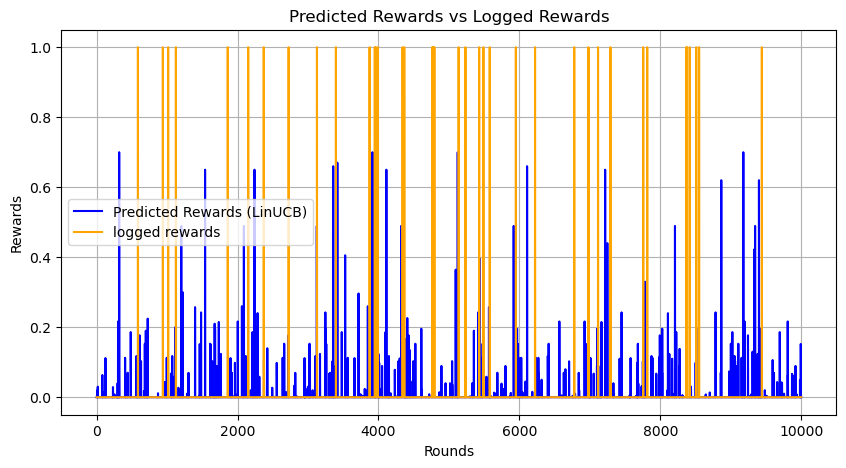

sum of all predicted rewards: 42.513446704448555
sum of all logged rewards: 38


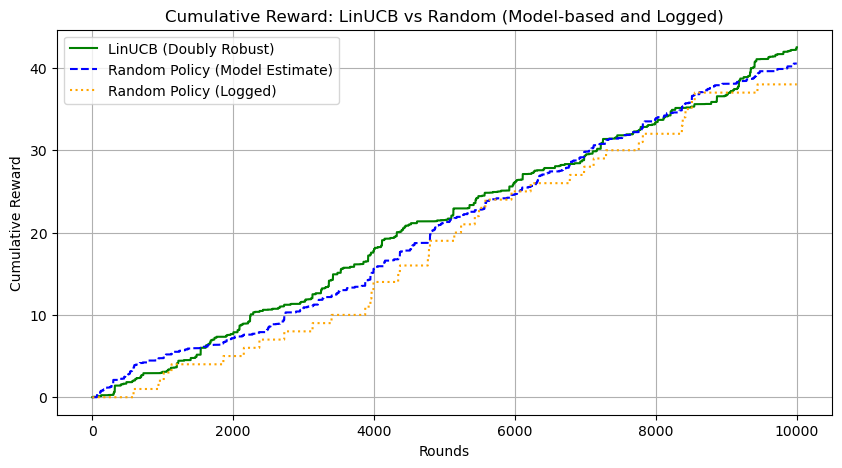

In [15]:
# --- Step 1: Prepare data ---
X_context = data["context"]
a_logged = np.array(data["action"])
r_logged = np.array(data["reward"])
pscore = np.array(data["pscore"])
a_target = np.array(results["chosen_actions"])  # LinUCB's chosen actions

# One-hot encode actions
action_onehot = OneHotEncoder(sparse=False)
a_onehot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

# Feature matrix: [context | one-hot(action)]
X_train = np.hstack([X_context, a_onehot])
y_reward = r_logged

# --- Step 2: Train reward model ---
reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
reward_model.fit(X_train, y_reward)

# --- Step 3: Predict rewards for LinUCB's chosen actions ---
a_target_onehot = action_onehot.transform(a_target.reshape(-1, 1))
X_test = np.hstack([X_context, a_target_onehot])
r_hat = reward_model.predict(X_test)

# -- step: predict reward for logged actions
a_logged_onehot = action_onehot.transform(a_logged.reshape(-1, 1))
X_logged = np.hstack([X_context, a_logged_onehot])
r_hat_random = reward_model.predict(X_logged)

# Cumulative expected reward from the random policy (Direct Method)
cumulative_dm_random = np.cumsum(r_hat_random)

# --- Step 4: Apply Doubly Robust Estimator ---
matches = a_target == a_logged
correction = np.zeros_like(r_logged)
correction[matches] = (r_logged[matches] - r_hat[matches]) / pscore[matches]
dr_estimates = r_hat + correction
cumulative_dr = np.cumsum(dr_estimates)

# --- Step 5: Compare with Random Logging Policy (baseline) ---
cumulative_random = np.cumsum(r_logged)

# intermediate, check if reward model predictions are reasonable

# compare predicted rewards with logged rewards
plt.figure(figsize=(10, 5))
plt.plot(r_hat, label="Predicted Rewards (LinUCB)", color="blue")
plt.plot(rewards, label="logged rewards", color="orange")
plt.title("Predicted Rewards vs Logged Rewards")
plt.xlabel("Rounds")
plt.ylabel("Rewards")
plt.legend()
plt.grid(True)
plt.show()

print(f"sum of all predicted rewards: {np.sum(r_hat)}")
print(f"sum of all logged rewards: {np.sum(rewards)}")


# --- Step 6: Plot Comparison ---
plt.figure(figsize=(10, 5))
plt.plot(cumulative_dr, label="LinUCB (Doubly Robust)", color="green")
plt.plot(cumulative_dm_random, label="Random Policy (Model Estimate)", color="blue", linestyle="--")
plt.plot(np.cumsum(r_logged), label="Random Policy (Logged)", color="orange", linestyle=":")
plt.title("Cumulative Reward: LinUCB vs Random (Model-based and Logged)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()


In the first plot, we can see how the approximated rewards make sense as they roughly align with the logged rewards.

In the second plot, we can see how the DR estimates enable us to do meaningful comparisons of the random policy and the linUCB policy. We plot the **logged rewards in yellow**, the **estimated rewards of the random policy in blue** and the **estimated rewards of the linUCB in green**. 

The green and blue line seem to behave very similiar, altough there could be some slight significant differences and improvements. To see this in more detail,  we will run this multiple times below to get significant results. When doing so, we will do it with different values of alpha.

Some reasons why the improvement is not large:
1. **Sparse rewards**: Only a small fraction of logged actions have non-zero rewards (clicks), limiting feedback.
2. **Low feedback overlap**: LinUCB rarely matches logged actions, so IPS contributes little (actually not at all as seen above), and DR relies mostly on the reward model.
3. **Context may be weakly informative**: If context features don’t correlate strongly with reward, LinUCB’s advantage is naturally limited.



### LinUCB with different alpha


Since individual offline evaluations can be noisy, we repeat the DR estimation over 50 random permutations (seeds). In each run:
- We shuffle the data to vary the training/test split implicitly.
- We retrain the reward model.
- We compute and accumulate DR estimates.
- We evaluate how LinUCB performs under different exploration levels:
- **α = 0.0**: Greedy (pure exploitation)
- **α = 0.1**: Balanced
- **α = 0.5**: More exploratory

Finally, we average the results to obtain more stable and statistically meaningful performance curves.

This lets us visualize expected cumulative performance across rounds, and makes differences between LinUCB and the baseline more interpretable.

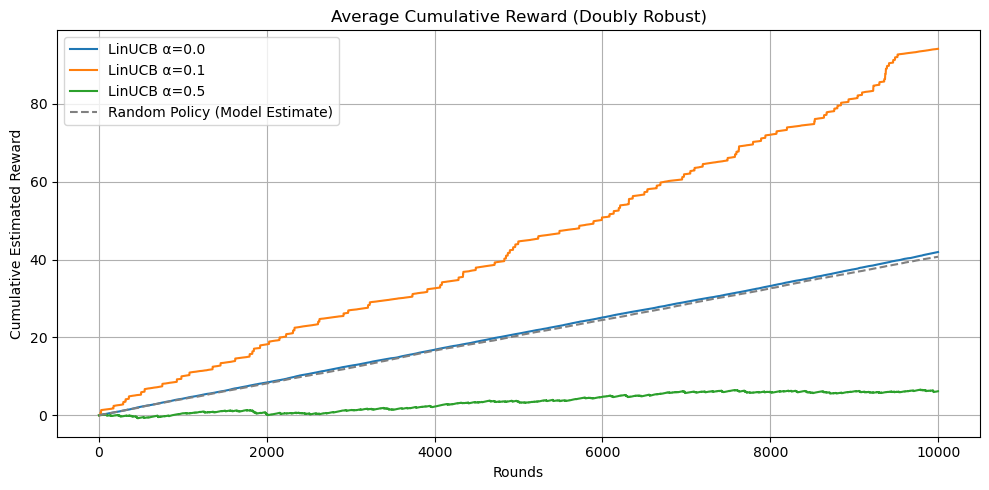

In [ ]:
n_seeds = 100
n_rounds = len(data["context"])
context_dim = data["context"].shape[1]
n_actions = data["n_actions"]

models = {
    "LinUCB α=0.0": results,
    "LinUCB α=0.1": results_01,
    "LinUCB α=0.5": results_05,
}

averages = {label: np.zeros(n_rounds) for label in models}
average_dm_random = np.zeros(n_rounds)

for seed in range(n_seeds):
    # Shuffle everything
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n_rounds)

    X_context = data["context"][idx]
    a_logged = np.array(data["action"])[idx]
    r_logged = np.array(data["reward"])[idx]
    pscore = np.array(data["pscore"])[idx]

    # One-hot encode actions
    action_onehot = OneHotEncoder(sparse=False)
    a_logged_1hot = action_onehot.fit_transform(a_logged.reshape(-1, 1))

    # Train reward model
    X_train = np.hstack([X_context, a_logged_1hot])
    reward_model = RandomForestRegressor(n_estimators=100, random_state=42)
    reward_model.fit(X_train, r_logged)

    # Predict reward for random policy (model-based)
    X_logged = np.hstack([X_context, a_logged_1hot])
    r_hat_random = reward_model.predict(X_logged)
    average_dm_random += np.cumsum(r_hat_random)

    for label, model in models.items():
        a_target = np.array(model["chosen_actions"])[idx]
        a_target_1hot = action_onehot.transform(a_target.reshape(-1, 1))
        X_target = np.hstack([X_context, a_target_1hot])
        r_hat = reward_model.predict(X_target)

        # Apply DR correction
        matches = a_target == a_logged
        correction = np.zeros_like(r_logged)
        correction[matches] = (r_logged[matches] - r_hat[matches]) / pscore[matches]
        dr_estimates = r_hat + correction
        averages[label] += np.cumsum(dr_estimates)

# Normalize over seeds
average_dm_random /= n_seeds
for label in averages:
    averages[label] /= n_seeds

# --- Plot ---
plt.figure(figsize=(10, 5))
for label, curve in averages.items():
    plt.plot(curve, label=label)
plt.plot(average_dm_random, label="Random Policy (Model Estimate)", linestyle="--", color="gray")
plt.title("Average Cumulative Reward (Doubly Robust)")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Estimated Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


As seen in the plot, moderate exploration (α=0.1) outperforms both extreme settings. This highlights a key trade-off in contextual bandits:
- Too little exploration can miss high-reward actions.
- Too much exploration may dilute learning from useful structure.

While the gains are not drastic, they are consistent—suggesting that LinUCB can modestly outperform the random policy when tuned appropriately.


## Compare with official LINUCB

/home/oliver/miniconda3/envs/RL/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/oliver/miniconda3/envs/RL/lib/python3.10/site-packages/obp/ope/meta.py:640: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95.0)` for the same effect.

  sns.barplot(


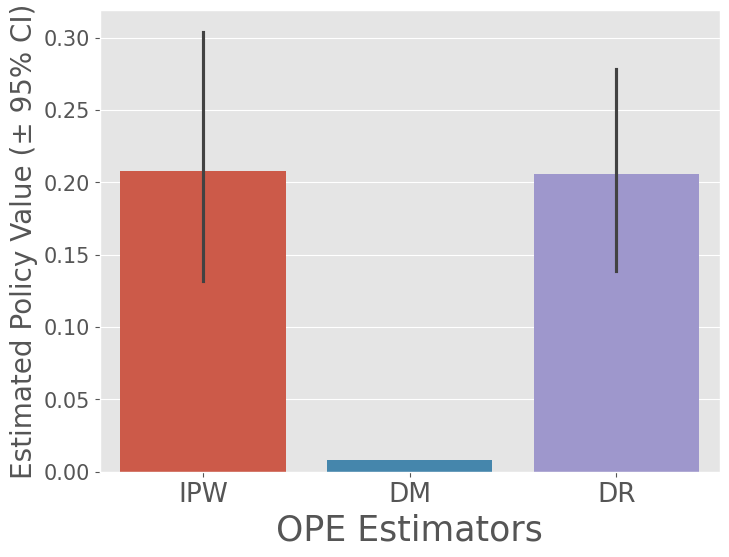

In [80]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from obp.policy import LinUCB
from obp.ope import DoublyRobust, RegressionModel, OffPolicyEvaluation
from obp.policy import IPWLearner


# --- Step 1: Load your logged bandit data ---
X_context = data["context"]                 # shape (n_rounds, d)
a_logged = np.array(data["action"])         # shape (n_rounds,)
r_logged = np.array(data["reward"])         # shape (n_rounds,)
pscore = np.array(data["pscore"])           # shape (n_rounds,)
n_actions = data["n_actions"]

bandit_feedback = {
    "n_rounds": len(X_context),
    "n_actions": n_actions,
    "context": X_context,
    "action": a_logged,
    "reward": r_logged,
    "pscore": pscore,
    "position": np.zeros(len(X_context), dtype=int),  # required by OBP
}


eval_policy = IPWLearner(n_actions=n_actions, base_classifier=LogisticRegression())
eval_policy.fit(
    context=X_context,
    action=a_logged,
    reward=r_logged,
    pscore=pscore
)
action_dist = eval_policy.predict(context=X_context)


regression_model = RegressionModel(
    n_actions=n_actions,
    base_model=LogisticRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=X_context,
    action=a_logged,
    reward=r_logged
)
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[IPW(), DM(), DR()]
)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
)

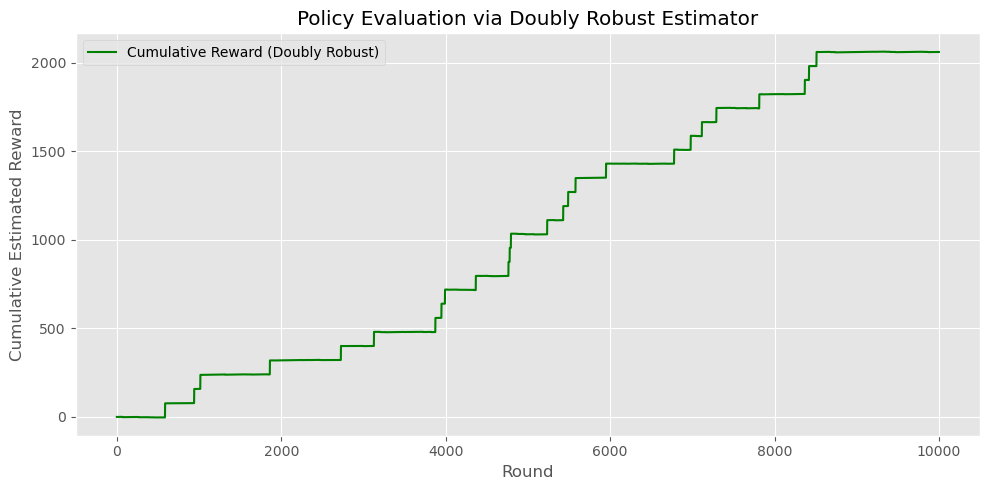

In [81]:
# --- Estimate per-round DR rewards ---
dr_per_round = dr_estimator._estimate_round_rewards(
    reward=bandit_feedback["reward"],
    action=bandit_feedback["action"],
    pscore=bandit_feedback["pscore"],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    action_dist=action_dist,
    action_by_evaluation_policy=np.argmax(action_dist, axis=1),
    )

# --- Accumulate rewards over time ---
cumulative_dr = np.cumsum(dr_per_round)

# --- Plot cumulative DR reward ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cumulative_dr, label="Cumulative Reward (Doubly Robust)", color="green")
plt.xlabel("Round")
plt.ylabel("Cumulative Estimated Reward")
plt.title("Policy Evaluation via Doubly Robust Estimator")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
